# Inference with Sansa, ensemble learning

In [1]:
import argparse
from mpi4py import MPI
import numpy as np
import h5py
import seaborn as sb
import matplotlib.pyplot as plt
from numpy.fft import irfft, rfft
from scipy.interpolate import RectBivariateSpline
from glob import glob
import emcee
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import keras_tuner as kt
# from lyanna_utils import * 
from chainconsumer import ChainConsumer
from lyanna.lyanna_utils import *
from lyanna.datautils import *
from lyanna.losses import *
from lyanna.sansa import *
#from livelossplot import PlotLossesKeras

In [2]:
plt.rcParams['font.size']       = 19
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['text.usetex']     = True
plt.rcParams['axes.facecolor']  = 'w'

In [3]:
N_gpus = len(tf.config.experimental.list_physical_devices('GPU'))
GPU_id = 1
# dist_strategy   = tf.distribute.MirroredStrategy()
print("Using TensorFlow {:s} with {:d} GPUs".format(tf.__version__, N_gpus))

Using TensorFlow 2.12.1 with 2 GPUs


In [4]:
op_path    = 'ensemble_kt_rSansa_Ext2/'
data_path  = '/project/ls-gruen/users/parth.nayak/lyanna_data/'+op_path
if not os.path.exists(op_path):
    os.mkdir(op_path)
if not os.path.exists(data_path):
    os.mkdir(data_path)

## Getting the input data

In [5]:
filespath  = '/project/ls-gruen/users/parth.nayak/lya_synthesis_data/rescaled_tdr_models/orthogonal_grid_models/'
Oracle     = FilesOracle(filespath)
T0s_orthogrid    = Oracle.T0s
gammas_orthogrid = Oracle.gammas
alphas     = Oracle.alphas
betas      = Oracle.betas
hfiles     = Oracle.hfiles

extpath    = '/project/ls-gruen/users/parth.nayak/lya_synthesis_data/rescaled_tdr_models/ortho_extended_grid_models/'
Oracle_ext = FilesOracle(extpath)
T0s_extorthogrid    = Oracle_ext.T0s
gammas_extorthogrid = Oracle_ext.gammas
alphas_ext = Oracle_ext.alphas
betas_ext  = Oracle_ext.betas
hfiles_ext = Oracle_ext.hfiles

filespath_offgrid  = '/project/ls-gruen/users/parth.nayak/lya_synthesis_data/rescaled_tdr_models/off_grid_models/range_2/'
Oracle_offgrid     = FilesOracle(filespath_offgrid)
hfiles_offgrid     = Oracle_offgrid.hfiles
T0s_offgrid        = Oracle_offgrid.T0s
gammas_offgrid     = Oracle_offgrid.gammas
alphas_offgrid     = Oracle_offgrid.alphas
betas_offgrid      = Oracle_offgrid.betas

k          = Oracle.k
k_full     = Oracle.k_full
v_h_skewer = Oracle.v_h_skewer_full
N_pixels   = Oracle.N_pixels_full
delta_v    = Oracle.delta_v_full

In [6]:
T0s_orthogrid_upscaled    = rescale_T0(T0s_orthogrid, mode = 'up')
gammas_orthogrid_upscaled = rescale_gamma(gammas_orthogrid, mode = 'up')

T0s_extorthogrid_upscaled    = rescale_T0(T0s_extorthogrid, mode = 'up')
gammas_extorthogrid_upscaled = rescale_gamma(gammas_extorthogrid, mode = 'up')

T0s_offgrid_upscaled    = rescale_T0(T0s_offgrid, mode = 'up')
gammas_offgrid_upscaled = rescale_gamma(gammas_offgrid, mode = 'up')

In [7]:
N_extrows_beta  = 2

if N_extrows_beta == 0:
    extension = False
elif N_extrows_beta>0:
    extension = True

In [8]:
indices_to_pick  = []
for indstart in range(3-N_extrows_beta, 3+N_extrows_beta):
    indices_to_pick.append(np.arange(indstart, indstart+len(T0s_extorthogrid), 3*2))
indices_to_pick  = np.array(indices_to_pick)
indices_to_pick  = np.ravel(indices_to_pick)
indices_to_pick  = np.sort(indices_to_pick)

In [9]:
N_skewers_each_train = 24000
N_skewers_each_valid = 8000
N_skewers_each_test  = 4000

data = get_data_for_sansa(
    training = False, validation = True, test = True, extension = False, smooth = True,
    N_sk_each_train = N_skewers_each_train,
    N_sk_each_valid = N_skewers_each_valid,
    N_sk_each_test  = N_skewers_each_test,
)

# train_spectra = data['training']
valid_spectra = data['validation']
test_spectra  = data['test']

In [10]:
test_spectra.shape, valid_spectra.shape

((484000, 517, 1), (968000, 517, 1))

In [11]:
fidfilename = '/project/ls-gruen/users/parth.nayak/lya_synthesis_data/fiducial_tdr_models/extracted_lya_abs_profiles_redshift_2.2_grid1_01722_S5678_cutoff_doppler.h5'
fid_test_spectra = sansa_test_data_inference(fidfilename, N_sk_to_pick = 2*N_skewers_each_test, smooth = True)
fid_test_spectra.shape

(8000, 517, 1)

In [12]:
T0_fid, gamma_fid  = fid_test_spectra[0, 512:514, 0]
T0_fid_upscaled    = rescale_T0(T0_fid, mode = 'up')
gamma_fid_upscaled = rescale_gamma(gamma_fid, mode = 'up') 

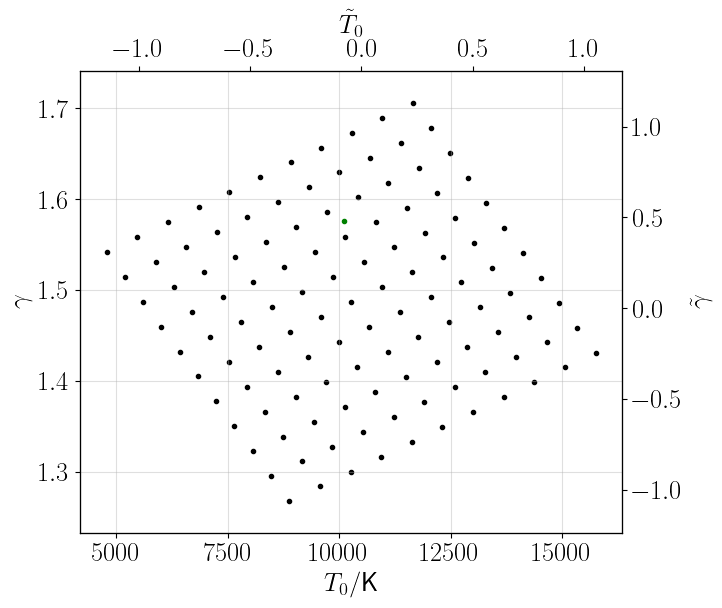

In [13]:
fig, ax = plt.subplots(figsize=(7,6))
# axs = fig.subplots(1, 2) 
ax.scatter(T0s_orthogrid_upscaled, gammas_orthogrid_upscaled, color = 'k', s = 9)
ax.scatter(rescale_T0(fid_test_spectra[0,512,0], mode = 'up'), rescale_gamma(fid_test_spectra[0,513,0], mode = 'up'), color = 'g', s = 9)
x_lims = [T0s_orthogrid_upscaled.min()-600, T0s_orthogrid_upscaled.max()+600]
y_lims = [gammas_orthogrid_upscaled.min()-0.035, gammas_orthogrid_upscaled.max()+0.035]
# plt.scatter(alphas, betas, color = 'k', s = 9)
# [axs[i].grid(alpha = 0.4) for i in range(2)]
ax.grid(alpha = 0.4)
ax.set_xlabel(r'$T_0$/K')
ax.set_ylabel(r'$\gamma$')
ax.set_xlim(*x_lims)
ax.set_ylim(*y_lims);

ax_y = ax.twinx()
ax_y.scatter(T0s_orthogrid, gammas_orthogrid, color = 'k', s = 9)
ax_y.set_ylim(rescale_gamma(y_lims[0]), rescale_gamma(y_lims[1]))
ax_y.set_ylabel(r'$\tilde{\gamma}$')

ax_x = ax.twiny()
ax_x.scatter(T0s_orthogrid, gammas_orthogrid, color = 'k', s = 9)
ax_x.set_xlim(rescale_T0(x_lims[0]), rescale_T0(x_lims[1]))
ax_x.set_xlabel(r'$\tilde{T}_0$');

# plt.savefig('orthogrid_space_twin_xy.pdf', bbox_inches = 'tight')
# axs[1].set_xlabel(r'$\alpha$')
# axs[1].set_ylabel(r'$\beta$')
# plt.subplots_adjust(wspace = 0.25);

In [14]:
T0s_arr_prior    = rescale_T0(np.linspace(T0s_orthogrid_upscaled.min()-600, T0s_orthogrid_upscaled.max()+600, 500))
gammas_arr_prior = rescale_gamma(np.linspace(gammas_orthogrid_upscaled.min()-0.025, gammas_orthogrid_upscaled.max()+0.025, 500))

T0s_prior, gammas_prior = np.meshgrid(T0s_arr_prior, gammas_arr_prior)

Prior_matrix = []
for T0 in T0s_arr_prior:
    tmp = []
    for gamma in gammas_arr_prior:
        tmp.append(Oracle.in_prior_volume(T0, gamma))
    Prior_matrix.append(tmp)
Prior_matrix = np.array(Prior_matrix).T
Prior_matrix.shape

(500, 500)

In [15]:
T0s_prior_upscaled    = rescale_T0(T0s_prior, mode = 'up')
gammas_prior_upscaled = rescale_gamma(gammas_prior, mode = 'up')

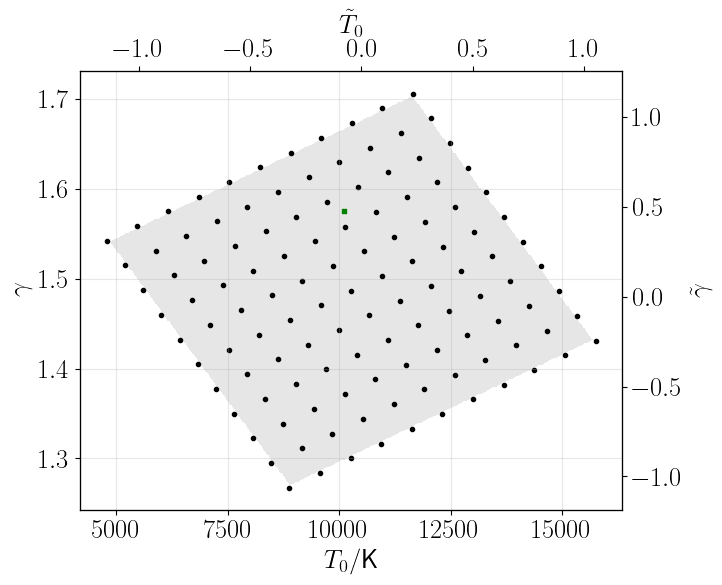

In [16]:
fig, ax = plt.subplots(figsize=(7,5.7))
# axs = fig.subplots(1, 2) 
ax.pcolormesh(T0s_prior_upscaled, gammas_prior_upscaled, Prior_matrix, cmap = 'binary', shading = 'auto', vmin = 0., vmax = 10.)
ax.scatter(T0s_orthogrid_upscaled, gammas_orthogrid_upscaled, color = 'k', s = 9, label = 'original',)
ax.scatter(T0_fid_upscaled, gamma_fid_upscaled, color = 'g', s = 9, marker = 's')
# ax.scatter(T0s_extorthogrid_upscaled[indices_to_pick], gammas_extorthogrid_upscaled[indices_to_pick], color = 'g', s = 20, label = 'extended', marker = 'x')
# x_lims = [T0s_extorthogrid_upscaled.min()-600, T0s_extorthogrid_upscaled.max()+600]
# y_lims = [gammas_extorthogrid_upscaled.min()-0.025, gammas_extorthogrid_upscaled.max()+0.025]

x_lims = [T0s_orthogrid_upscaled.min()-600, T0s_orthogrid_upscaled.max()+600]
y_lims = [gammas_orthogrid_upscaled.min()-0.025, gammas_orthogrid_upscaled.max()+0.025]

# plt.scatter(alphas, betas, color = 'k', s = 9)
# [axs[i].grid(alpha = 0.4) for i in range(2)]
# ax.legend(loc = 'upper right')
ax.grid(alpha = 0.3)
ax.set_xlabel(r'$T_0$/K')
ax.set_ylabel(r'$\gamma$')
ax.set_xlim(*x_lims)
ax.set_ylim(*y_lims);

ax_y = ax.twinx()
# ax_y.scatter(T0s_orthogrid, gammas_orthogrid, color = 'k', s = 9)
# ax_y.scatter(T0s_extorthogrid[indices_to_pick], gammas_extorthogrid[indices_to_pick], color = 'g', s = 9,)
# ax_y.set_xlim(rescale_T0(x_lims[0]), rescale_T0(x_lims[1]))
ax_y.set_ylim(rescale_gamma(y_lims[0]), rescale_gamma(y_lims[1]))
ax_y.set_ylabel(r'$\tilde{\gamma}$')

ax_x = ax.twiny()
# ax_x.scatter(T0s_orthogrid, gammas_orthogrid, color = 'k', s = 9)
# ax_x.scatter(T0s_extorthogrid[indices_to_pick], gammas_extorthogrid[indices_to_pick], color = 'g', s = 9,)

ax_x.set_xlim(rescale_T0(x_lims[0]), rescale_T0(x_lims[1]))
# ax_x.set_ylim(rescale_gamma(y_lims[0]), rescale_gamma(y_lims[1]))
ax_x.set_xlabel(r'$\tilde{T}_0$');

# plt.savefig('orthogrid_space_twin_xy_with_shaded_prior_&_fiducial_tdr.pdf', bbox_inches = 'tight', dpi = 400)
# axs[1].set_xlabel(r'$\alpha$')
# axs[1].set_ylabel(r'$\beta$')
# plt.subplots_adjust(wspace = 0.25);

## Setting up Sansa

In [18]:
tf.keras.backend.clear_session()
with tf.device(f'/device:GPU:{GPU_id}'):
# with dist_strategy.scope():
    rsansa = create_rSansa()
rsansa.summary()

Model: "rSansa"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 1)]     0           []                               
                                                                                                  
 conv_0 (Conv1D)                (None, 256, 16)      272         ['input_1[0][0]']                
                                                                                                  
 conv_1 (Conv1D)                (None, 256, 16)      4112        ['conv_0[0][0]']                 
                                                                                                  
 conv_2 (Conv1D)                (None, 256, 16)      4112        ['conv_1[0][0]']                 
                                                                                             

In [20]:
weights_path = data_path+f'retraining_tuner_impl_2/'

In [21]:
N_members_committee = 10
best_network_idx = 7
best_epochs  = np.array([962,936,743,635,578,1345,650,1139,849,1062])+1
indsort_nets = np.array([7, 3, 5, 2, 8, 9, 6, 4, 0, 1]) 

In [22]:
Ws_rsansa = np.load(op_path+f'retraining_tuner_impl_2/rsansa_committee_W_matrices_retrained_kt2_{N_members_committee}runs.npy')
Ds_rsansa = np.load(op_path+f'retraining_tuner_impl_2/rsansa_committee_D_vectors_retrained_kt2_{N_members_committee}runs.npy');

In [28]:
# Ws_rsansa[0], np.linalg.inv(Ws_rsansa[0])

## Predicting with Sansa

In [23]:
rsansa_committee_predictions      = []
test_rsansa_committee_predictions = []
for i in range(N_members_committee):
    print(f"Predicting from run {i+1} of {N_members_committee}", end = '\r')
    with tf.device(f'/device:GPU:{GPU_id}'):
        rsansa.load_weights(weights_path+f'run_{i}/W_at_epoch_{best_epochs[i]}')
        rsansa_committee_predictions.append(rsansa.predict(valid_spectra[:, :512, :]))
        test_rsansa_committee_predictions.append(rsansa.predict(test_spectra[:, :512, :]))
rsansa_committee_predictions      = np.array(rsansa_committee_predictions)
test_rsansa_committee_predictions = np.array(test_rsansa_committee_predictions)

15125/15125 [==============================] - 28s 2ms/step


In [24]:
rsansa_committee_predictions.shape, test_rsansa_committee_predictions.shape

((10, 968000, 5), (10, 484000, 5))

In [25]:
rsansa_committee_covariance_matrices = np.zeros((N_members_committee, 2,2))
rsansa_committee_covariance_determinants = []
for i in range(N_members_committee):
    cov = np.cov(rsansa_committee_predictions[i, :, :2], rowvar = False)
    rsansa_committee_covariance_matrices[i] = cov
    rsansa_committee_covariance_determinants.append(np.linalg.det(cov))
rsansa_committee_covariance_determinants = np.array(rsansa_committee_covariance_determinants)
rsansa_committee_covariance_matrices.shape, rsansa_committee_covariance_determinants.shape

((10, 2, 2), (10,))

In [26]:
# idx_of_inference_tester = 50
# tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]
committee_transformed_network_covariance_matrices = np.zeros((N_members_committee,2,2))
committee_transformed_network_covariance_determinants = np.zeros(N_members_committee)
for i in range(N_members_committee):
    c1s = np.exp(rsansa_committee_predictions[i, :, 2])
    c2s = np.exp(rsansa_committee_predictions[i, :, 3])
    c3s = rsansa_committee_predictions[i, :, 4] 

    Sigma_inverse_matrices_rsansa    = FromCholeskyToPrecision(c1s, c2s, c3s)

    Sigma_inverse_matrix_mean_rsansa = np.mean(Sigma_inverse_matrices_rsansa, axis = 0)
    Sigma_matrix_mean_rsansa         = np.linalg.inv(Sigma_inverse_matrix_mean_rsansa)
    Sigma_matrix_mean_rsansa         = Ws_rsansa[i].dot(Sigma_matrix_mean_rsansa.dot(Ws_rsansa[i].T))
    
    committee_transformed_network_covariance_matrices[i] = Sigma_matrix_mean_rsansa
    committee_transformed_network_covariance_determinants[i] = np.linalg.det(Sigma_matrix_mean_rsansa)
committee_transformed_network_covariance_matrices.shape, committee_transformed_network_covariance_determinants.shape

((10, 2, 2), (10,))

In [27]:
# idx_of_inference_tester = 50
# tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]
test_committee_transformed_network_covariance_matrices = np.zeros((N_members_committee,2,2))
test_committee_transformed_network_covariance_determinants = np.zeros(N_members_committee)
for i in range(N_members_committee):
    c1s = np.exp(test_rsansa_committee_predictions[i, :, 2])
    c2s = np.exp(test_rsansa_committee_predictions[i, :, 3])
    c3s = test_rsansa_committee_predictions[i, :, 4] 

    Sigma_inverse_matrices_rsansa    = FromCholeskyToPrecision(c1s, c2s, c3s)

    Sigma_inverse_matrix_mean_rsansa = np.mean(Sigma_inverse_matrices_rsansa, axis = 0)
    Sigma_matrix_mean_rsansa         = np.linalg.inv(Sigma_inverse_matrix_mean_rsansa)
    Sigma_matrix_mean_rsansa         = Ws_rsansa[i].dot(Sigma_matrix_mean_rsansa.dot(Ws_rsansa[i].T))
    
    test_committee_transformed_network_covariance_matrices[i] = Sigma_matrix_mean_rsansa
    test_committee_transformed_network_covariance_determinants[i] = np.linalg.det(Sigma_matrix_mean_rsansa)
test_committee_transformed_network_covariance_matrices.shape, test_committee_transformed_network_covariance_determinants.shape

((10, 2, 2), (10,))

## Linearly transforming point predictions

In [28]:
rsansa_transformed_committee_predictions = np.zeros_like(rsansa_committee_predictions)
for i in range(N_members_committee):
    rsansa_transformed_committee_predictions[i,:,0] = Ws_rsansa[i,0,0]*rsansa_committee_predictions[i,:,0] + Ws_rsansa[i,0,1]*rsansa_committee_predictions[i,:,1] + Ds_rsansa[i,0]
    rsansa_transformed_committee_predictions[i,:,1] = Ws_rsansa[i,0,1]*rsansa_committee_predictions[i,:,0] + Ws_rsansa[i,1,1]*rsansa_committee_predictions[i,:,1] + Ds_rsansa[i,1]
# mean_rsansa_transformed_committee_predictions = np.mean(rsansa_transformed_committee_predictions, axis = 0)

In [29]:
test_rsansa_transformed_committee_predictions = np.zeros_like(test_rsansa_committee_predictions)
for i in range(N_members_committee):
    test_rsansa_transformed_committee_predictions[i,:,0] = Ws_rsansa[i,0,0]*test_rsansa_committee_predictions[i,:,0] + Ws_rsansa[i,0,1]*test_rsansa_committee_predictions[i,:,1] + Ds_rsansa[i,0]
    test_rsansa_transformed_committee_predictions[i,:,1] = Ws_rsansa[i,0,1]*test_rsansa_committee_predictions[i,:,0] + Ws_rsansa[i,1,1]*test_rsansa_committee_predictions[i,:,1] + Ds_rsansa[i,1]
# mean_test_rsansa_transformed_committee_predictions = np.mean(test_rsansa_transformed_committee_predictions, axis = 0)

In [30]:
mean_rsansa_transformed_committee_predictions      = np.average(rsansa_transformed_committee_predictions, axis = 0, weights = 1./committee_transformed_network_covariance_determinants)
mean_test_rsansa_transformed_committee_predictions = np.average(test_rsansa_transformed_committee_predictions, axis = 0, weights = 1./test_committee_transformed_network_covariance_determinants)

In [31]:
rsansa_transformed_committee_predictions.shape, test_rsansa_transformed_committee_predictions.shape

((10, 968000, 5), (10, 484000, 5))

In [32]:
mean_rsansa_transformed_committee_predictions.shape, mean_test_rsansa_transformed_committee_predictions.shape

((968000, 5), (484000, 5))

In [33]:
# rSansa

Means_rsansa_test = []
# Invcovs_rsansa    = []
for idx_of_inference_tester in range(len(hfiles)):
    tester_slice_rsansa    = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test, :2]
    rsansa_point_estimates = mean_test_rsansa_transformed_committee_predictions[tester_slice_rsansa] #arya_predictions[tester_slice_arya, :2]
    rsansa_mean_estimates  = np.mean(rsansa_point_estimates, axis = 0)
    Means_rsansa_test.append(rsansa_mean_estimates)
    # Invcovs_rsansa.append(np.linalg.inv(rsansa_covariance_estimate))
    
Means_rsansa_test = np.array(Means_rsansa_test)

In [34]:
Means_rsansa_test.shape

(121, 2)

## Creating a likelihood model for rSansa Committee

In [35]:
# rSansa
N_rSansa = 100

Means_rsansa_committee_interpolation    = []
Invcovs_rsansa_committee  = []
for idx_of_inference_tester in range(len(hfiles)):
    tester_slice_rsansa    = np.s_[idx_of_inference_tester*N_skewers_each_valid : (idx_of_inference_tester+1)*N_skewers_each_valid, :2]
    rsansa_point_estimates = mean_rsansa_transformed_committee_predictions[tester_slice_rsansa] #arya_predictions[tester_slice_arya, :2]
    rsansa_mean_estimates  = np.mean(rsansa_point_estimates, axis = 0)
    # print(dsansa_mean_estimates)
    rsansa_covariance_estimate = np.cov(rsansa_point_estimates, rowvar = False)/N_rSansa
    # print(dsansa_covariance_estimate)
    Means_rsansa_committee_interpolation.append(rsansa_mean_estimates)
    Invcovs_rsansa_committee.append(np.linalg.inv(rsansa_covariance_estimate))
    
Means_rsansa_committee_interpolation    = np.array(Means_rsansa_committee_interpolation)
Invcovs_rsansa_committee  = np.array(Invcovs_rsansa_committee)
Means_rsansa_committee_interpolation.shape, Invcovs_rsansa_committee.shape

((121, 2), (121, 2, 2))

In [36]:
order_interp = 3
mean_T0_interpolator_rsansa_committee = RectBivariateSpline(
            Oracle.alphas[::11],
            Oracle.betas[:11],
            Means_rsansa_committee_interpolation[:,0].reshape(11,11),
            kx = order_interp, ky = order_interp,
)

mean_gamma_interpolator_rsansa_committee = RectBivariateSpline(
            Oracle.alphas[::11],
            Oracle.betas[:11],
            Means_rsansa_committee_interpolation[:,1].reshape(11,11),
            kx = order_interp, ky = order_interp,
)

invcov_interpolators_rsansa_committee = []
for i in [0,1,3]:
    invcov_interpolators_rsansa_committee.append(
        RectBivariateSpline(
            Oracle.alphas[::11],
            Oracle.betas[:11],
            Invcovs_rsansa_committee[:,i//2, i%2].reshape(11,11),
            kx = order_interp, ky = order_interp,
        )
    )

In [37]:
N_grid      = 100
alphas_test = np.linspace(min(Oracle.alphas)+0.15, max(Oracle.alphas)-0.15, N_grid)
betas_test  = np.linspace(min(Oracle.betas)+0.05,  max(Oracle.betas)-0.05,  N_grid)

# T0s_test, gammas_test    = change_basis(alphas_test, betas_test)

# T0s_testm, gammas_testm = np.meshgrid(T0s_test, gammas_test)
alphas_m, betas_m = np.meshgrid(alphas_test, betas_test)
alphas_m = np.ravel(alphas_m); betas_m = np.ravel(betas_m)

T0s_testm, gammas_testm = change_basis(alphas_m, betas_m)

logdetC     = np.zeros(T0s_testm.shape)
T0_model    = np.zeros(T0s_testm.shape)
gamma_model = np.zeros(T0s_testm.shape)
for i in range(len(T0s_testm)):
    # for j in range(len(gammas_test)):
        # alpha, beta = change_basis(T0s_test[i], gammas_test[j])
    C00 = invcov_interpolators_rsansa_committee[0](alphas_m[i], betas_m[i])[0,0]
    C01 = invcov_interpolators_rsansa_committee[1](alphas_m[i], betas_m[i])[0,0]
    C11 = invcov_interpolators_rsansa_committee[2](alphas_m[i], betas_m[i])[0,0]
    logdetC[i]  = -np.log(C00*C11 - C01**2) 
    T0_model[i] = mean_T0_interpolator_rsansa_committee(alphas_m[i], betas_m[i])[0,0]
    gamma_model[i] = mean_gamma_interpolator_rsansa_committee(alphas_m[i], betas_m[i])[0,0]

T0s_testm    = T0s_testm.reshape(N_grid,N_grid)
gammas_testm = gammas_testm.reshape(N_grid,N_grid)
logdetC      = logdetC.reshape(N_grid,N_grid)
T0_model     = T0_model.reshape(N_grid, N_grid)
gamma_model  = gamma_model.reshape(N_grid, N_grid)

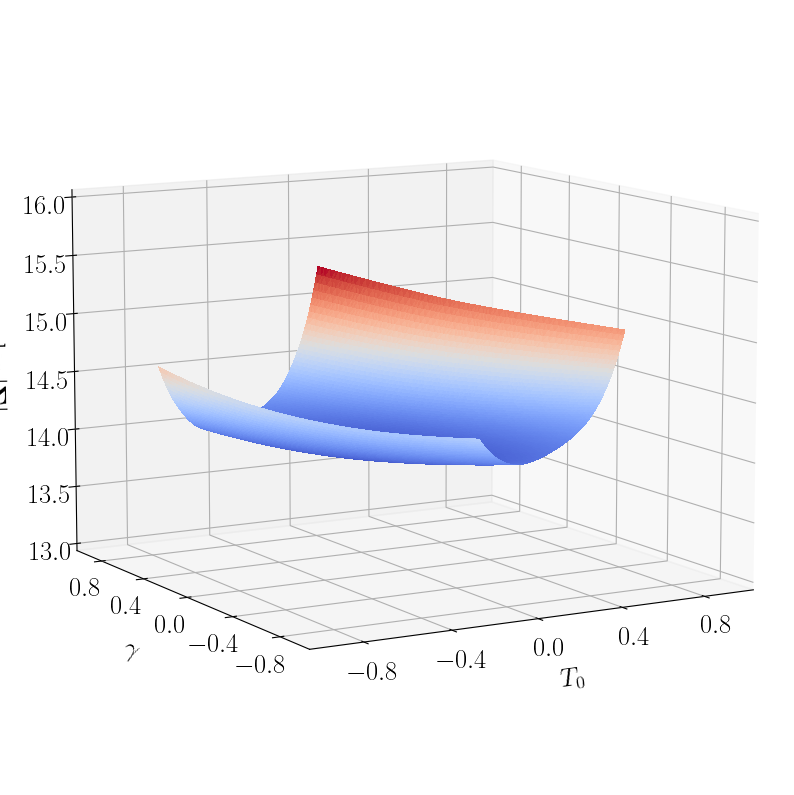

In [38]:
fig = plt.figure(figsize = (10,13))
ax  = fig.subplots(subplot_kw={"projection":"3d"})
ax.view_init(elev = 10, azim = 240)
T0s_test    = np.ravel(T0s_testm)
gammas_test = np.ravel(gammas_testm)
surf = ax.plot_trisurf(T0s_test, gammas_test, -np.ravel(logdetC), linewidth = 0, antialiased = False, cmap = 'coolwarm', alpha = 1.0)
# surf = ax.plot_surface(alphas_m, betas_m, logdetC, linewidth = 0, antialiased = False, cmap = 'RdBu')
# surf1 = ax.plot_surface(T0s_testm, gammas_testm, T0_model, linewidth = 0, antialiased = False, cmap = 'RdBu')
# surf2 = ax.plot_surface(alphas_m, betas_m, gamma_model, linewidth = 0, antialiased = False, cmap = 'RdBu')
# ax.scatter3D(T0s_orthogrid, gammas_orthogrid, np.ones(T0s_orthogrid.shape)*13.5, color = 'k', s = 4, alpha = 1.0)
filled = (T0s_testm<max(T0s_orthogrid))&(T0s_testm>min(T0s_orthogrid))&(gammas_testm<max(gammas_orthogrid))&(gammas_testm>min(gammas_orthogrid))
# ax.voxels(filled, facecolors = [0,0,0,0.5])# -1.*np.ones(len(T0s_orthogrid)), 1.*np.ones(len(T0s_orthogrid)), alpha = 0.3, color = 'grey')
# ax.scatter3D(T0s_testm, gammas_testm, gammas_testm, color = 'k', s = 1, alpha = 0.3)
# ax.set_zlim3d(1000, 12000)
# ax.set_zscale('log')
# ax.set_xlabel(r'$\alpha$')
ax.set_xlabel('$T_0$', labelpad = 15)
# ax.set_ylabel(r'$\beta$')
ax.set_ylabel(r'$\gamma$', labelpad = 15)
ax.set_zlabel(r'$-\log \vert \mathbf{\Sigma} \vert$', labelpad = 15)
ax.set_xlim(-1.0, 1.0)
ax.set_xticks([-0.8,-0.4,0.,0.4,0.8])
ax.set_yticks([-0.8,-0.4,0.,0.4,0.8])
ax.set_ylim(-1.0, 1.0)
ax.set_zlim(13, 16);
# ax.set_zticks([16, 15, 14,]);
# fig.colorbar(surf, shrink = 0.5, location = 'left');
# plt.tight_layout();
# ax.grid(alpha = 0.3)
# plt.savefig(op_path+f'tuner_impl_{impl_id}/figures/rsansa_likelihood_covariance_model.pdf', bbox_inches = 'tight')

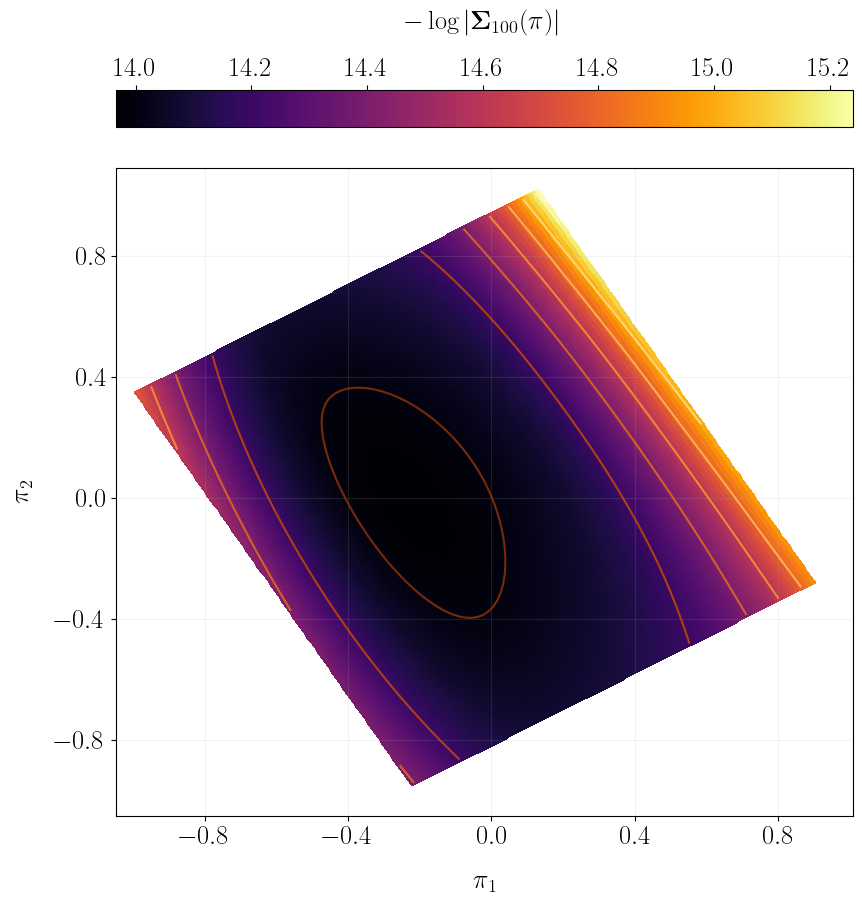

In [39]:
fig = plt.figure(figsize = (9,9.5))
ax  = fig.subplots(1) #subplot_kw={"projection":"3d"})
con = ax.contour(T0s_testm, gammas_testm, -logdetC, alpha = 0.8, cmap = 'YlOrBr_r', levels = 6)
pcm = ax.pcolormesh(T0s_testm, gammas_testm, -logdetC, cmap = 'inferno', shading = 'auto', rasterized = True)
ax.grid(alpha = 0.15)
# ax.tick_params(top = True, labeltop = True, bottom = False, labelbottom = False)
ax.set_xlabel(r'$\pi_1$', labelpad = 15)
ax.set_ylabel(r'$\pi_2$', labelpad = 15)

ax.set_xlim(-1.05, 1.01)
ax.set_xticks([-0.8,-0.4,0.,0.4,0.8])
ax.set_yticks([-0.8,-0.4,0.,0.4,0.8])
ax.set_ylim(-1.05, 1.09);
cp = plt.colorbar(pcm, ax = ax, shrink = 1.0, location = 'top');
cp.set_label(label = r'$-\log \vert \mathbf{\Sigma}_{100} (\pi) \vert$', labelpad = 20)
plt.tight_layout();
# cc = plt.colorbar(con, cax = cp.ax, orientation = 'horizontal');
# plt.savefig(op_path+'figures/committee_likelihood_model_C_presentation_version.pdf', bbox_inches = 'tight', dpi = 300)

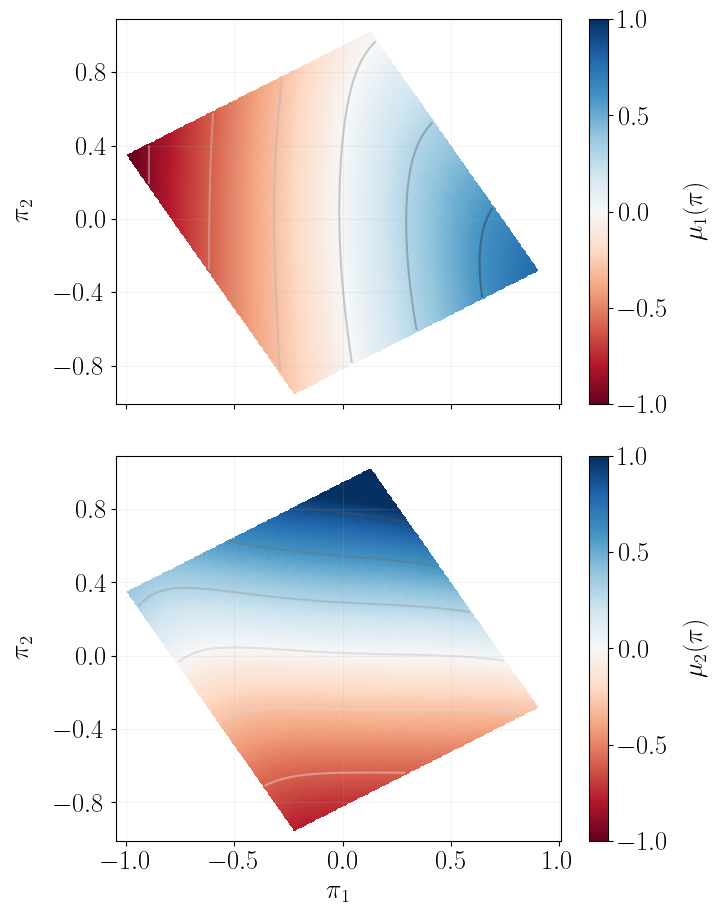

In [41]:
fig  = plt.figure(figsize=(7.5,9.5))
axs  = fig.subplots(2, 1, sharex = True) #subplot_kw={"projection":"3d"})
con0 = axs[0].contour(T0s_testm, gammas_testm, T0_model, alpha = 0.4, cmap = 'Greys', levels = 6)
pcm0 = axs[0].pcolormesh(T0s_testm, gammas_testm, T0_model, cmap = 'RdBu', shading = 'auto', rasterized = True, vmin = -1, vmax = 1)
# axs[0].set_xlabel(r'$\mu_1$', labelpad = 15)
axs[0].set_ylabel(r'$\pi_2$', labelpad = 15)
axs[0].tick_params(top = False, labeltop = False, bottom = True, labelbottom = False)
axs[0].set_xlim(-1.05, 1.01)
# axs[0].set_xticks([-0.8,-0.4,0.,0.4,0.8])
axs[0].set_yticks([-0.8,-0.4,0.,0.4,0.8])
axs[0].set_ylim(-1.01, 1.09)
axs[0].grid(alpha = 0.15);
cb1 = plt.colorbar(pcm0, ax = axs[0], shrink = 1.0, location = 'right')
cb1.set_label(label = r'$\mu_1 (\pi)$', labelpad = 10);


# plt.subplot(2,2,4) #subplot_kw={"projection":"3d"})
con1 = axs[1].contour(T0s_testm, gammas_testm, gamma_model, alpha = 0.4, cmap = 'Greys', levels = 6)
pcm1 = axs[1].pcolormesh(T0s_testm, gammas_testm, gamma_model, cmap = 'RdBu', shading = 'auto', rasterized = True, vmin = -1, vmax = 1)
# axs[1].set_xlabel(r'$\mu_1$', labelpad = 15)
# axs[1].set_ylabel(r'$\mu_2$', labelpad = 15)
axs[1].set_ylabel(r'$\pi_2$', labelpad = 15)
axs[1].tick_params(top = False, labeltop = False, bottom = True, labelbottom = True)
axs[1].set_xlabel(r'$\pi_1$')
axs[1].set_xlim(-1.05, 1.01)
# axs[1].set_xticks([-0.8,-0.4,0.,0.4,0.8])
axs[1].set_yticks([-0.8,-0.4,0.,0.4,0.8])
axs[1].set_ylim(-1.01, 1.09)
axs[1].grid(alpha = 0.15);
cb2 = plt.colorbar(pcm1, ax = axs[1], shrink = 1.0, location = 'right')
# cc = plt.colorbar(con1, cax = cb2.ax, orientation = 'horizontal');
cb2.set_label(label = r'$\mu_2 (\pi)$', labelpad = 10);
plt.tight_layout();
# plt.savefig(op_path+f'tuner_impl_{impl_id}/figures/rsansa_likelihood_covariance_model.pdf', bbox_inches = 'tight')
# plt.savefig(op_path+'figures/committee_likelihood_model_mu_presentation_version.pdf', bbox_inches = 'tight', dpi = 300)

## Test with Fiducial TDR model (off-grid)

### With the committee

In [42]:
fid_test_preds_committee      = []
for i in range(N_members_committee):
    print(f"Predicting from run {i+1} of {N_members_committee}", end = '\r')
    with tf.device(f'/device:GPU:{GPU_id}'):
        rsansa.load_weights(weights_path+f'run_{i}/W_at_epoch_{best_epochs[i]}')
        fid_test_preds_committee.append(rsansa.predict(fid_test_spectra[:, :512, :]))
fid_test_preds_committee      = np.array(fid_test_preds_committee)

250/250 [==============================] - 1s 2ms/step


In [43]:
fid_test_preds_committee_transformed = np.zeros_like(fid_test_preds_committee)
for i in range(N_members_committee):
    fid_test_preds_committee_transformed[i,:,0] = Ws_rsansa[i,0,0]*fid_test_preds_committee[i,:,0] + Ws_rsansa[i,0,1]*fid_test_preds_committee[i,:,1] + Ds_rsansa[i,0]
    fid_test_preds_committee_transformed[i,:,1] = Ws_rsansa[i,0,1]*fid_test_preds_committee[i,:,0] + Ws_rsansa[i,1,1]*fid_test_preds_committee[i,:,1] + Ds_rsansa[i,1]

In [44]:
fid_test_committee_transformed_covariance_matrices = np.zeros((N_members_committee,2,2))
fid_test_committee_transformed_covariance_determinants = []
for i in range(N_members_committee):
    cov = np.cov(fid_test_preds_committee_transformed[i, :, :2], rowvar = False)
    fid_test_committee_transformed_covariance_matrices[i] = cov
    fid_test_committee_transformed_covariance_determinants.append(np.linalg.det(cov))
fid_test_committee_transformed_covariance_determinants = np.array(fid_test_committee_transformed_covariance_determinants)
fid_test_committee_transformed_covariance_matrices.shape, fid_test_committee_transformed_covariance_determinants.shape

((10, 2, 2), (10,))

In [45]:
test_subset_idx = 0
N_sk_for_inference = 8000
subset_sl = np.s_[test_subset_idx*N_sk_for_inference : (test_subset_idx+1)*N_sk_for_inference]

In [46]:
# idx_of_inference_tester = 50
# tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]
fid_test_committee_transformed_network_covariance_matrices1 = np.zeros((N_members_committee,2,2))
fid_test_committee_transformed_network_covariance_determinants1 = np.zeros(N_members_committee)
for i in range(N_members_committee):
    c1s = np.exp(fid_test_preds_committee[i, subset_sl, 2])
    c2s = np.exp(fid_test_preds_committee[i, subset_sl, 3])
    c3s = fid_test_preds_committee[i, subset_sl, 4] 

    Sigma_inverse_matrices_rsansa    = FromCholeskyToPrecision(c1s, c2s, c3s)

    Sigma_inverse_matrix_mean_rsansa = np.mean(Sigma_inverse_matrices_rsansa, axis = 0)
    Sigma_matrix_mean_rsansa         = np.linalg.inv(Sigma_inverse_matrix_mean_rsansa)
    Sigma_matrix_mean_rsansa         = Ws_rsansa[i].dot(Sigma_matrix_mean_rsansa.dot(Ws_rsansa[i].T))
    
    fid_test_committee_transformed_network_covariance_matrices1[i] = Sigma_matrix_mean_rsansa
    fid_test_committee_transformed_network_covariance_determinants1[i] = np.linalg.det(Sigma_matrix_mean_rsansa)
fid_test_committee_transformed_network_covariance_matrices1.shape, fid_test_committee_transformed_network_covariance_determinants1.shape

((10, 2, 2), (10,))

In [47]:
mean_fid_test_pred_committee_transformed = np.average(fid_test_preds_committee_transformed, axis = 0, weights = 1./fid_test_committee_transformed_network_covariance_determinants1)[:, :2]
mean_fid_test_pred_committee_transformed.shape

(8000, 2)

In [48]:
mean_fid_test_pred_committee_transformed_upscaled = rescale_chain(mean_fid_test_pred_committee_transformed, mode = 'up') 
mean_fid_test_pred_committee_transformed_upscaled.shape

(8000, 2)

## Inference with Sansa

### With the committee

In [49]:
# Fiducial model test case, committee

def compute_likelihood_rsansa_fid_committee(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.mean(mean_fid_test_pred_committee_transformed, axis = 0) #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_committee(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_committee(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_committee[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_fid_committee(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa                  = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_committee_fid = sampler_rsansa.flatchain[500000:,:]

In [50]:
# N_rSansa  = 1000
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_fid, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_fid - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1000) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_fid_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_fid_upscaled = rescale_chain(rsansa_flatchain_committee_fid_upscaled, mode = 'up')

rsansa_flatchain_committee_fid_upscaled[:,0] = rsansa_flatchain_committee_fid_upscaled[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_committee_fid_upscaled[:,1] = rsansa_flatchain_committee_fid_upscaled[:,1] / gamma_fid_upscaled - 1

In [51]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_fid, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_fid - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/100) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_fid_upscaled100 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_fid_upscaled100 = rescale_chain(rsansa_flatchain_committee_fid_upscaled100, mode = 'up')

rsansa_flatchain_committee_fid_upscaled100[:,0] = rsansa_flatchain_committee_fid_upscaled100[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_committee_fid_upscaled100[:,1] = rsansa_flatchain_committee_fid_upscaled100[:,1] / gamma_fid_upscaled - 1

### Loading conventional summary MCMC chains for comparison

In [52]:
N_MCMC = 100
mcmc_flatchain_upscaled_crosscorr100 = np.load(op_path+f'mcmc_chains_for_comparison/mcmc_crosscorr_fiducial_tdr_{N_MCMC}LOS.npy')
mcmc_flatchain_upscaled_ps1d100      = np.load(op_path+f'mcmc_chains_for_comparison/mcmc_ps1d_fiducial_tdr_{N_MCMC}LOS.npy')

In [53]:
N_MCMC = 1000
mcmc_flatchain_upscaled_crosscorr = np.load(op_path+f'mcmc_chains_for_comparison/mcmc_crosscorr_fiducial_tdr_{N_MCMC}LOS.npy')
mcmc_flatchain_upscaled_ps1d      = np.load(op_path+f'mcmc_chains_for_comparison/mcmc_ps1d_fiducial_tdr_{N_MCMC}LOS.npy')

In [54]:
N_MCMC = 1000
mcmc_flatchain_upscaled_crosscorr_1k = np.load(op_path+f'mcmc_chains_for_comparison/mcmc_crosscorr_fiducial_tdr_{N_MCMC}LOS_1000sk.npy')
mcmc_flatchain_upscaled_ps1d_1k      = np.load(op_path+f'mcmc_chains_for_comparison/mcmc_ps1d_fiducial_tdr_{N_MCMC}LOS_1000sk.npy')

In [55]:
N_MCMC = 1000
mcmc_flatchain_upscaled_crosscorr_1k_fullcov = np.load(op_path+f'mcmc_chains_for_comparison/mcmc_crosscorr_fiducial_tdr_{N_MCMC}LOS_1000sk_fullcov.npy')
mcmc_flatchain_upscaled_ps1d_1k_fullcov      = np.load(op_path+f'mcmc_chains_for_comparison/mcmc_ps1d_fiducial_tdr_{N_MCMC}LOS_1000sk_fullcov.npy')

### Plotting the posterior contours

T0 =  10104.151919484138
gamma =  1.575970380306244


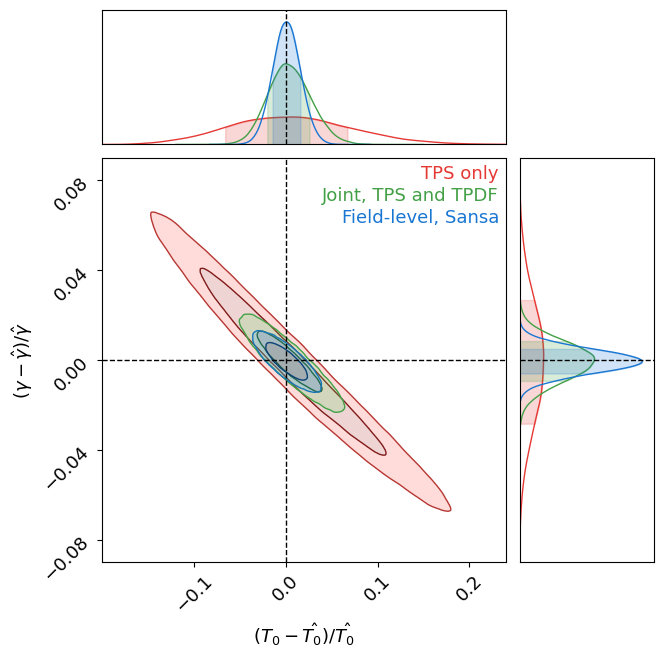

In [56]:
# print('Fiducial')
print('T0 = ', T0_fid_upscaled)
print('gamma = ', gamma_fid_upscaled)

c   = ChainConsumer()

c.add_chain(
    mcmc_flatchain_upscaled_ps1d100, #_1k_fullcov,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'TPS only', #'TPS only',
)
c.add_chain(
    mcmc_flatchain_upscaled_crosscorr100, #_1k_fullcov,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Joint, TPS and TPDF', #'Joint, TPS \& TPDF',
)
c.add_chain(
    rsansa_flatchain_committee_fid_upscaled100,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Field-level, Sansa', #r'Field-level, \textsc{Sansa}',
)

c.configure(
    # kde = 3.0,
    summary = False,
    # sigmas  = [0,1,2,3],
    # linewidths = 0.7,
    tick_font_size = 13, #19,
    label_font_size = 13, #19,
    # bar_shade   = [False, True, True, False, True],
    shade_alpha = 0.2, #[0.0, 0.2, 0.2, 0.0, 0.2], #0.15,
    # shade_gradient = 1.5,
    colors = ['red', 'green', 'blue', '#4B0082', '#054907'], # #
    watermark_text_kwargs = {'alpha':0.2, 'rotation':135}
)

fig = c.plotter.plot(
    figsize = (6.5,6.5),
    truth   = [0., 0.],
    # filename = op_path+f'tuner_impl_{impl_id}/figures/rSansa_posterior_fid_rolled_flipped_likelihood-based.pdf', #Arya{impl_id_arya}_Sansa{impl_id_sansa}_{idx_of_inference_tester}.pdf', #
    legend  = True,
    #extents = [(-2.2,2.2),(-1.1, 1.1)],
    extents = [(-0.2,0.24),(-0.09, 0.09)],
    #watermark = 'Preliminary'
)

ax = fig.axes[2]

c.plotter.restore_rc_params()
# plt.savefig(op_path+'figures/rSansa_posterior_fiducial_with_summaries_crosscorr_presentation_version.pdf', bbox_inches = 'tight')

In [57]:
def chi2(chain, truth):
    Cov = np.cov(chain.T)
    inv_Cov = np.linalg.inv(Cov)
    # print(Cov.shape)
    c2 = 0
    for i in range(len(chain)):
        c2 += (chain[i] - truth).dot(inv_Cov.dot((chain[i] - truth).T))
    return c2/len(chain) #(chain-truth).dot(Cov.dot((chain-truth).T))

In [60]:
truth = np.array([T0_fid_upscaled, gamma_fid_upscaled])
chi2_committee = chi2((rsansa_flatchain_committee_fid_upscaled100 + 1.)*truth, truth)
# chi2_bestnet   = chi2((rsansa_flatchain_best_fid_upscaled + 1.)*truth, truth)

In [61]:
print("Committee:\t", chi2_committee)
# print("Best network:\t", chi2_bestnet)

Committee:	 2.013235810739746


In [62]:
detC_ps1d   = np.linalg.det(np.cov(mcmc_flatchain_upscaled_ps1d100.T))
# detC_nocorr = np.linalg.det(np.cov(mcmc_flatchain_upscaled_nocorr.T))
detC_corr   = np.linalg.det(np.cov(mcmc_flatchain_upscaled_crosscorr100.T))
# detC_rsansa_best      = np.linalg.det(np.cov(rsansa_flatchain_best_fid_upscaled100.T))
detC_rsansa_committee = np.linalg.det(np.cov(rsansa_flatchain_committee_fid_upscaled100.T))

# print(np.sqrt(detC_ps1d/detC_rsansa_best))
# print(np.sqrt(detC_corr/detC_rsansa_best))
# print('\n')
print(np.sqrt(detC_ps1d/detC_rsansa_committee))
print(np.sqrt(detC_corr/detC_rsansa_committee))
# print('\n')
# print(np.sqrt(detC_rsansa_best/detC_rsansa_committee))

5.620275227704546
1.700849132475472
